In [1]:
import mujoco
import mediapy as media
import numpy as np 


In [2]:
model = mujoco.MjModel.from_xml_path("unitree_a1/scene.xml")
renderer = mujoco.Renderer(model, width=800, height=600)

In [3]:
label = f'stand_twist'
data_file = 'data/a1/walking/'+ label +'.csv'

data_array = np.genfromtxt(data_file, delimiter=',', skip_header=100, skip_footer=100)
timespan = data_array[:, 0]- data_array[0, 0]
sampling = np.mean(np.diff(timespan))
quaternion = data_array[:, 1:5]
linear_velocity = data_array[:, 5:8]
joint_angles = data_array[:, 11:23] 
joint_velocity = data_array[:, 23:35] 
joint_torques = data_array[:, 35:47]
contacts = data_array[:, 47:]
final_time = timespan[-1]

In [4]:

data = mujoco.MjData(model)

In [5]:
mujoco.mj_resetData(model, data)  # Reset state and time.
mujoco.mj_step(model, data)

In [6]:
data.qpos[2] = 0.3
data.qpos[3:7] = quaternion[0]
data.qpos[7:] = joint_angles[0]

In [7]:
mujoco.mj_step(model, data)

""

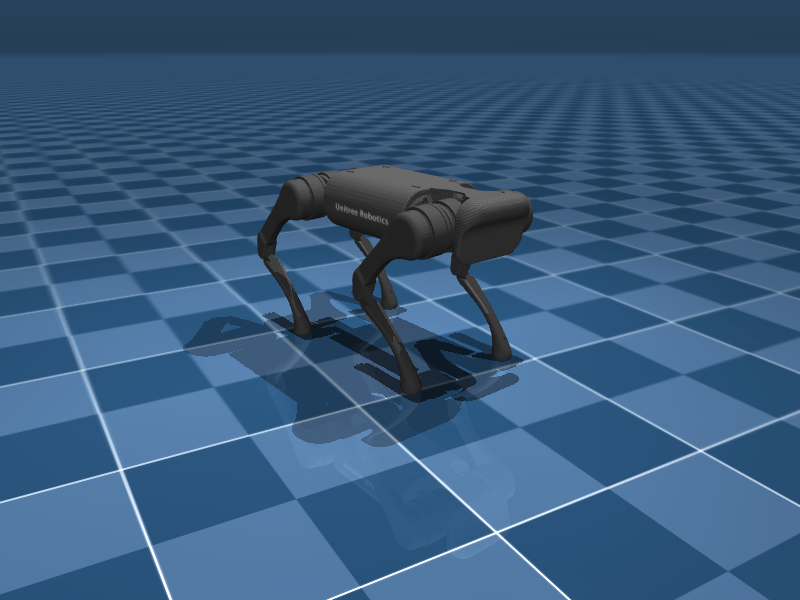

In [8]:
renderer.update_scene(data)
media.show_image(renderer.render())

In [9]:
mujoco.mj_resetData(model, data)  # Reset state and time.
mujoco.mj_step(model, data)
model.opt.timestep = 1/1000

framerate = 30  # (Hz)
data.qpos[0] = 0.
data.qpos[1] = 0.
data.qpos[2] = 0.3
# Simulate and display video.
frames = []

for i in range(1000):
    time = timespan[i]

    data.qpos[3:7] = quaternion[i]
    data.qpos[7:] = joint_angles[i]
    mujoco.mj_kinematics(model, data)
    if len(frames) < time * framerate:
        renderer.update_scene(data)
        pixels = renderer.render()
        frames.append(pixels)
media.show_video(frames, fps=framerate)


In [10]:

from scipy import interpolate

In [11]:
joint_angles_t = interpolate.interp1d(timespan, joint_angles, axis = 0)


In [12]:
mujoco.mj_resetData(model, data)  # Reset state and time.
mujoco.mj_step(model, data)
model.opt.timestep = 1/1000

scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
model.vis.map.force = 0.005

framerate = 30  # (Hz)

# Simulate and display video.
frames = []
data.qpos[0] = 0.
data.qpos[1] = 0.
data.qpos[2] = 0.3
data.qpos[3:7] = quaternion[0]
data.qpos[7:] = joint_angles[0]
data.qpos[7:] = joint_angles[0]
slow_down_factor = 1

while data.time <= 0.4*final_time:
    time = data.time
    data.ctrl = joint_angles_t(time )
    mujoco.mj_step(model, data)
    if len(frames) < slow_down_factor*time * framerate:
        renderer.update_scene(data, scene_option = scene_option)
        pixels = renderer.render()
        frames.append(pixels)
media.show_video(frames, fps=framerate)

